## 데이터셋 다운로드

In [1]:
!pip install -q torchvision

In [2]:
from torchvision.datasets import OxfordIIITPet

raw_dataset = OxfordIIITPet(
    root="./data/oxfordpet",
    download=True,
    target_types="segmentation"
)

100%|██████████| 792M/792M [00:36<00:00, 21.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.8MB/s]


## Overall Process Implementation

In [1]:
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import Compose
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm
import logging
from PIL import Image
from torch import Tensor
from random import shuffle
from torchvision.transforms import InterpolationMode


### Model implementation

In [2]:
class DoubleConv(nn.Module):
  """(conv > bn > relu) * 2 """
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)

class Up(nn.Module):
  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [3]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=False):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = (DoubleConv(n_channels, 64))
    self.down1 = (Down(64, 128))
    self.down2 = (Down(128, 256))
    self.down3 = (Down(256, 512))
    factor = 2 if bilinear else 1
    self.down4 = (Down(512, 1024 // factor))
    self.up1 = (Up(1024, 512 // factor, bilinear))
    self.up2 = (Up(512, 256 // factor, bilinear))
    self.up3 = (Up(256, 128 // factor, bilinear))
    self.up4 = (Up(128, 64, bilinear))
    self.outc = (OutConv(64, n_classes))

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

  def use_checkpointing(self):
    self.inc = torch.utils.checkpoint(self.inc)
    self.down1 = torch.utils.checkpoint(self.down1)
    self.down2 = torch.utils.checkpoint(self.down2)
    self.down3 = torch.utils.checkpoint(self.down3)
    self.down4 = torch.utils.checkpoint(self.down4)
    self.up1 = torch.utils.checkpoint(self.up1)
    self.up2 = torch.utils.checkpoint(self.up2)
    self.up3 = torch.utils.checkpoint(self.up3)
    self.up4 = torch.utils.checkpoint(self.up4)
    self.outc = torch.utils.checkpoint(self.outc)

## Dataset class (Single Transforms)

In [37]:
class SegmentationDataset(Dataset):
  """Custom dataset """
  def __init__(self, images, masks, transforms):
    self.images = images
    self.masks = masks
    self.transforms = transforms

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = self.images[idx]
    mask_path = self.masks[idx]

    # open
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert('L') # GRAYSCALE

    # Apply transform
    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)
      # transforms.toTensor() 를 하게되면 image/255 를 해서 다시 곱해주고 -1 을 해주는것.
      mask = (mask*255).squeeze().to(torch.int64)
      mask -= 1 # 해당 데이터가 1,2,3 부터 레이블링이 되어있다고 함.

    return image, mask

## Dataset class (Multi Transforms)
- random augment 는 같은 랜덤이 들어가야해서 self.transforms 를 각자 적용하면 안됨.
- RandomCrop : 이미지 자체를 CRopping
- Resize : 전체 이미지의 해상도를 바꿔주는것( interpolation / nearest 를 써야함)

In [4]:
class JointRandomHorizontalFlip:
  def __init__(self, p=0.5):
    self.p = p

  def __call__(self, img, mask):
    if random.random() < self.p:
      img = TF.hflip(img)
      mask = TF.hflip(mask)

    return img, mask

class JointRandomCrop:
  def __init__(self, size):
    self.size = size

  def __call__(self, img, mask):
    i, j, h, w = transforms.RandomCrop.get_params(
        img, output_size=self.size)
    img = TF.crop(img, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    return img, mask

class JointRandomRotate:
  def __init__(self, degrees):
    self.degrees = degrees

  def __call__(self, img, mask):
    angle = transforms.RandomRotation.get_params([-self.degrees, self.degrees])
    img = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR, fill=1)
    mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST, fill=1)

    return img, mask

class JointCompose:
  def __init__(self, transforms_list):
    self.transforms = transforms_list

  def __call__(self, img, mask):

    for t in self.transforms:
      img, mask = t(img, mask)

    return img, mask

class SegmentationDataset_multi(Dataset):
  def __init__(self, images, masks, crop_size, train=True):
    self.images = images
    self.masks = masks
    self.image_size = (256, 256)

    # Random 의 경우,
    if train:
      self.joint_transforms = JointCompose([
          JointRandomHorizontalFlip(p=0.5),
          # JointRandomRotate(degrees=10),
          JointRandomCrop(crop_size)
      ])
      # Only Image,
      self.image_transform = transforms.Compose([
          # transforms.Resize(self.image_size, interpolation=InterpolationMode.BILINEAR),
          transforms.ColorJitter(
              brightness=0.2,
              contrast=0.2,
              saturation=0.2,
              hue=0.2
          ),
          transforms.ToTensor(), # 0~255 가 0~1 로 변환
          transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                  std=(0.229, 0.224, 0.225))
          ])
    else:
      self.joint_transforms = None
      # Only Image,
      self.image_transform = transforms.Compose([
          transforms.ToTensor(), # 0~255 가 0~1 로 변환
          transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                  std=(0.229, 0.224, 0.225))
          ])

    # Only Mask,
    # - interpolation : Nearest / float normalize 같은거 하면 안됨.
    self.mask_transform = transforms.Compose([
        # transforms.Resize(self.image_size, interpolation=InterpolationMode.NEAREST),
        transforms.PILToTensor(), # 값 유지
        transforms.Lambda(lambda x : x.long()-1) # oxfordpet 데이터 mask 가 1부터 시작해서
    ])


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(self.images[idx]).convert('RGB')
    mask = Image.open(self.masks[idx])

    # RESIZE
    img = img.resize(self.image_size, resample=Image.BILINEAR)
    mask = mask.resize(self.image_size, resample=Image.NEAREST)

    img, mask = self.joint_transforms(img, mask)
    img = self.image_transform(img)
    mask = self.mask_transform(mask)
    mask = mask.squeeze()

    return img, mask

## Train loop

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [6]:
# Variables
epochs = 5
batch_size = 16
learning_rate = 1e-3
bilinear = True
classes = 3
image_size = (256, 256)

model = UNet(n_channels=3, n_classes=classes, bilinear=bilinear)
model = model.to(device)

print(f'Network:\n'
      f'\t{model.n_channels} input channels\n'
      f'\t{model.n_classes} output channels (classes)\n'
      f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

Network:
	3 input channels
	3 output channels (classes)
	Bilinear upscaling


In [7]:
## Dataset
image_path = "/content/data/oxfordpet/oxford-iiit-pet/images"
mask_path = "/content/data/oxfordpet/oxford-iiit-pet/annotations/trimaps"
split_rate = 0.2

# Create a list of image paths
img_paths = sorted([
    os.path.join(image_path, name)
    for name in os.listdir(image_path)
    if name.endswith('.jpg')
])

# Create a list of mask paths
mask_paths = sorted([
    os.path.join(mask_path, name)
    for name in os.listdir(mask_path)
    if not name.startswith('.') and name.endswith('.png')
])

tmp = list(zip(img_paths, mask_paths))
shuffle(tmp)
img_paths, mask_paths = zip(*tmp)
img_paths, mask_paths = list(img_paths), list(mask_paths)
train_imgs = img_paths[int(split_rate*len(img_paths)):]
train_masks = mask_paths[int(split_rate*len(mask_paths)):]
test_imgs = img_paths[:int(split_rate * len(img_paths))]
test_masks = mask_paths[:int(split_rate * len(mask_paths))]

# SINGLE TRANSFORMS
# transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.ToTensor()
# ])

# train_dataset = SegmentationDataset(train_imgs, train_masks, transform)
# test_dataset = SegmentationDataset(test_imgs, test_masks, transform)

# Multi Transforms
train_dataset = SegmentationDataset_multi(train_imgs, train_masks, crop_size=image_size)
test_dataset = SegmentationDataset_multi(test_imgs, test_masks, crop_size=image_size)
print('Train images: {}\n Test images: {}'.format(len(train_dataset), len(test_dataset)))

train_loader = DataLoader(train_dataset, batch_size=batch_size,
           num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
           num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=30, eta_min=1e-6
)

Train images: 5912
 Test images: 1478


## Dice loss (reference)
입력으로 softmax / one hot 모두 거쳐서 넣어줘야함.

In [56]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    # input / target: (B, C, H, W)
    # flatten : (B*C, H, W) 로 변환
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

## Dice loss (from chatgpt)
아래 함수 안에서 one hot / softmax 처리 다 해줌.

In [8]:
def dice_coeff_binary(prob, target, eps):
  # prob : after sigmoid, shape = (B, 1, H, W) or (B, H, W)
  if prob.dim() == 4:
    prob = prob.squeeze(1) # (B, H, W)
  if target.dim() == 4:
    target = target.squeeze(1)

  prob = prob.contiguous().view(prob.size(0), -1) # (B, H*W) Shape 으로 변환
  target = target.contiguous().view(target.size(0), -1)

  inter = (prob * target).sum(dim=1)
  union = prob.sum(dim=1) + target.sum(dim=1)
  dice = (2*inter+eps) / (union+eps)
  return dice.mean()


def dice_coeff_multiclass(prob, target, eps=1e-6):
  # prob: (B, C, H, W)
  # Target: (B, H, W)
  num_classes = prob.shape[1]
  target_one_hot = F.one_hot(target, num_classes) # (B, H, W, C)
  target_one_hot = target_one_hot.permute(0, 3, 1, 2) # (B, C, H, W)
  target_one_hot = target_one_hot.float()

  dices = []
  for c in range(num_classes):
    dices.append(dice_coeff_binary(prob[:, c], target_one_hot[:, c], eps=eps))

  return torch.stack(dices).mean()

def dice_loss_multiclass(logits: torch.Tensor, target: torch.Tensor):
  prob = torch.softmax(logits, dim=1)
  return 1 - dice_coeff_multiclass(prob, target)

## Metric (mIOU)

In [15]:
def compute_miou(pred, target, num_classes, ignore_index=None, eps=1e-6):
  """
  pred : (B, H, W)
  target: (B, H, W)
  """

  assert pred.shape == target.shape

  if ignore_index is not None:
    mask = target != ignore_index
    pred  = pred[mask]
    target = target[mask]

  ious = []
  for c in range(num_classes):
    pred_c = (pred == c)
    target_c = (target == c)
    inter = (pred_c & target_c).sum().float() # 교집합
    union = pred_c.sum().float() + target_c.sum().float() - inter # 합집합

    if union == 0:
      continue
    ious.append((inter+eps) / (union+eps))

  if len(ious) == 0:
    return torch.tensor(0.0)
  return torch.stack(ious).mean()

In [16]:
best_loss = float('inf')
checkpoint_path = "/content/segmentation_checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)
num_classes = model.n_classes

for epoch in range(1, epochs+1):
  model.train()
  train_loss = 0.0
  train_miou_total = 0.0
  train_batches = 0
  test_loss = 0.0
  test_miou_total = 0.0
  test_batches = 0

  # for i, (images, masks) in tqdm( enumerate(train_loader)):
  for images, masks in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
    images, masks = images.to(device), masks.to(device)
    pred = model(images)
    # CE : pred (B, C, H, W) raw logits, target=(B, H, W) long() [0,1,2 class] 을 기대
    loss = criterion(pred, masks)
    # dice_loss_ = dice_loss(
    #     F.softmax(pred, dim=1).float(),
    #     F.one_hot(masks, model.n_classes).permute(0, 3, 1, 2).float(),
    #     multiclass=True
    #   )

    dice_loss_ = dice_loss_multiclass(pred, masks)
    loss += dice_loss_

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    with torch.no_grad():
      preds = torch.argmax(pred, dim=1)
      miou = compute_miou(preds, masks, num_classes)
      train_miou_total += miou.item()
      train_batches += 1

  avg_train_loss = train_loss / len(train_loader)
  avg_train_miou = train_miou_total / train_batches

  # evaluate
  with torch.no_grad():
    model.eval()
    # for i, (images, masks) in tqdm(enumerate(test_loader)):
    for images, masks in tqdm(test_loader, desc=f"Epoch {epoch} [Eval]"):
      images, masks = images.to(device), masks.to(device)
      pred = model(images)
      loss = criterion(pred, masks)
      # loss += dice_loss(
      #   F.softmax(pred, dim=1).float(),
      #   F.one_hot(masks, model.n_classes).permute(0, 3, 1, 2).float(),
      #   multiclass=True
      # )
      dice_loss_ = dice_loss_multiclass(pred, masks)
      test_loss += loss.item()

      preds = torch.argmax(pred, dim=1)
      miou = compute_miou(preds, masks, num_classes=num_classes)
      test_miou_total += miou.item()
      test_batches += 1

    # Calculate
    avg_test_loss = test_loss / len(test_loader)
    avg_test_miou = test_miou_total / test_batches

    print(f"[Epoch {epoch}] "
          f"Train Loss: {avg_train_loss:.4f}, Train mIoU: {avg_train_miou:.4f} | "
          f"Test Loss: {avg_test_loss:.4f}, Test mIoU: {avg_test_miou:.4f}")


  scheduler.step()
  # Save checkpoint
  ckpt_file = os.path.join(checkpoint_path, "best_model.pth")
  if avg_test_loss < best_loss:
    best_loss = avg_test_loss
    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': best_loss
      }, ckpt_file)
    print(f"📌 Best model saved at epoch {epoch} (loss={best_loss:.4f})")

Epoch 1 [Eval]: 100%|██████████| 1478/1478 [00:31<00:00, 46.47it/s]


[Epoch 1] Train Loss: 0.6778, Train mIoU: 0.6646 | Test Loss: 0.3826, Test mIoU: 0.6598
📌 Best model saved at epoch 1 (loss=0.3826)


Epoch 2 [Train]:  61%|██████    | 226/370 [02:22<01:30,  1.58it/s]


KeyboardInterrupt: 

## Test

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch

def colorize_mask(mask: torch.Tensor, num_classes: int = 20):
    """
    mask: (H, W), class index
    return: (H, W, 3) uint8
    """
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()

    cmap = cm.get_cmap('tab20', num_classes)  # tab20은 최대 20색, 그 이상이면 다른 cmap 써도 됨

    # 정규화: 0~num_classes-1 → 0~1
    mask_norm = mask.astype(np.float32) / max(num_classes - 1, 1)

    colored = cmap(mask_norm)[..., :3]  # RGBA 중 RGB만
    colored = (colored * 255).astype(np.uint8)
    return colored

def visualize_multi_class(mask_pred, mask_gt=None, num_classes=20):
    pred_rgb = colorize_mask(mask_pred, num_classes)

    if mask_gt is not None:
        gt_rgb = colorize_mask(mask_gt, num_classes)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.title("GT");   plt.imshow(gt_rgb);   plt.axis('off')
        plt.subplot(1,2,2); plt.title("Pred"); plt.imshow(pred_rgb); plt.axis('off')
    else:
        plt.figure(figsize=(5,5))
        plt.title("Pred"); plt.imshow(pred_rgb); plt.axis('off')

    plt.show()

def visualize_with_image(image, mask_pred, mask_gt=None, num_classes=20):
    if torch.is_tensor(image):
        image = image.cpu().permute(1,2,0).numpy()  # (3,H,W)→(H,W,3)

    pred_rgb = colorize_mask(mask_pred, num_classes)

    plt.figure(figsize=(13,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(image);     plt.axis('off')
    plt.subplot(1,3,2); plt.title("Pred");  plt.imshow(pred_rgb);  plt.axis('off')

    if mask_gt is not None:
        gt_rgb = colorize_mask(mask_gt, num_classes)
        plt.subplot(1,3,3); plt.title("GT"); plt.imshow(gt_rgb);   plt.axis('off')

    plt.show()

0it [00:00, ?it/s]/tmp/ipython-input-1120124869.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_classes)  # tab20은 최대 20색, 그 이상이면 다른 cmap 써도 됨


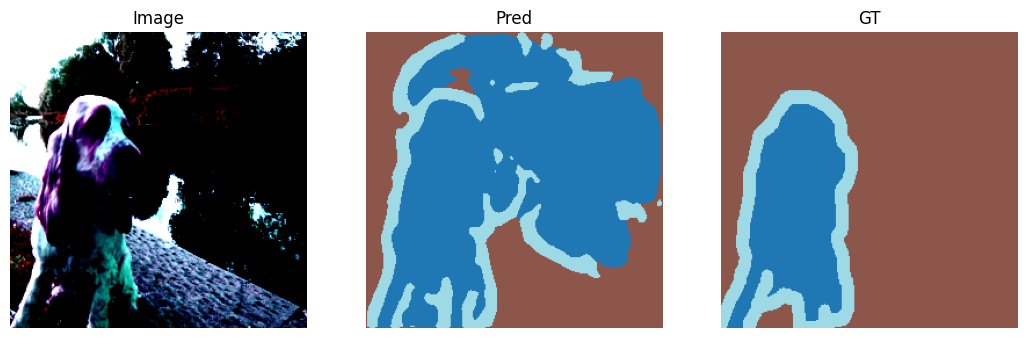

1it [00:00,  2.10it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


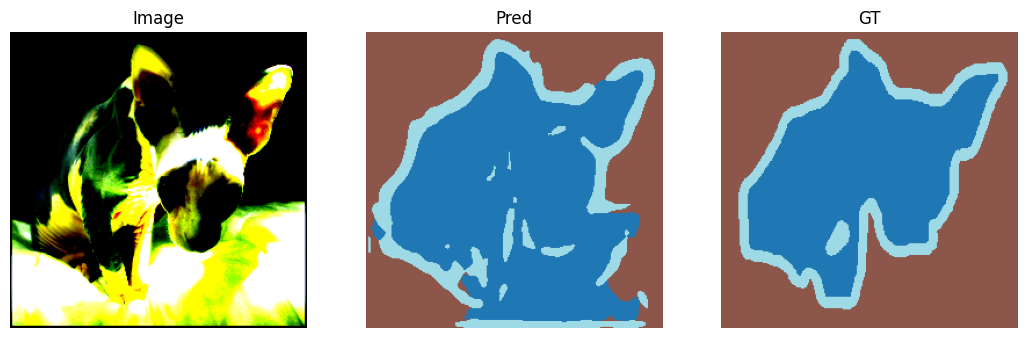

2it [00:00,  2.22it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.0190852].


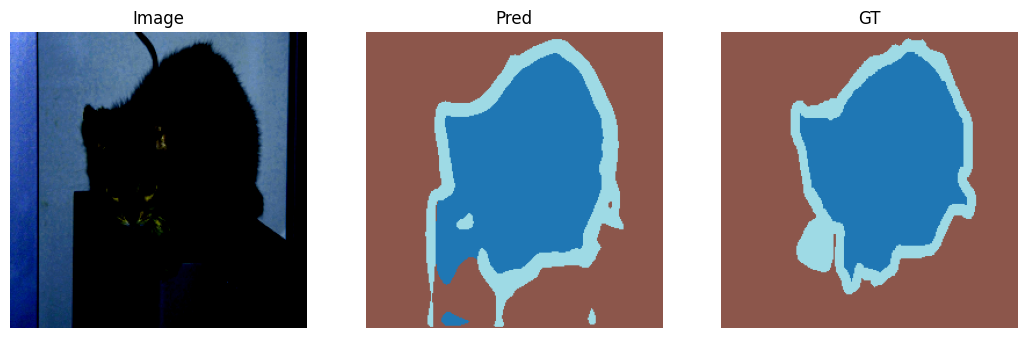

3it [00:01,  2.97it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].


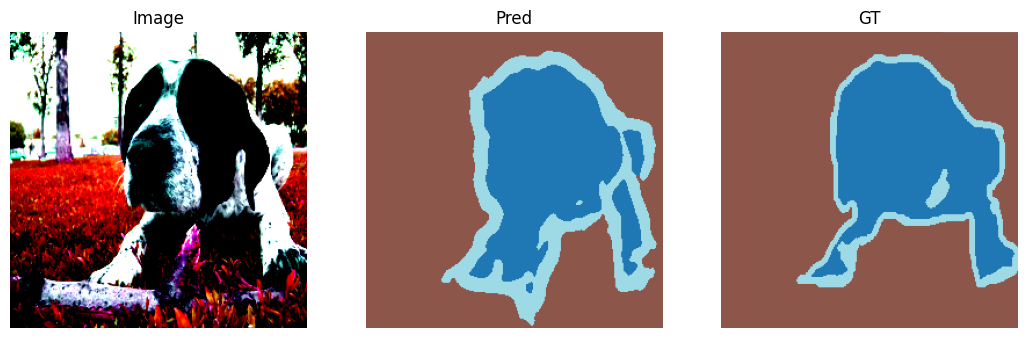

4it [00:01,  3.50it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


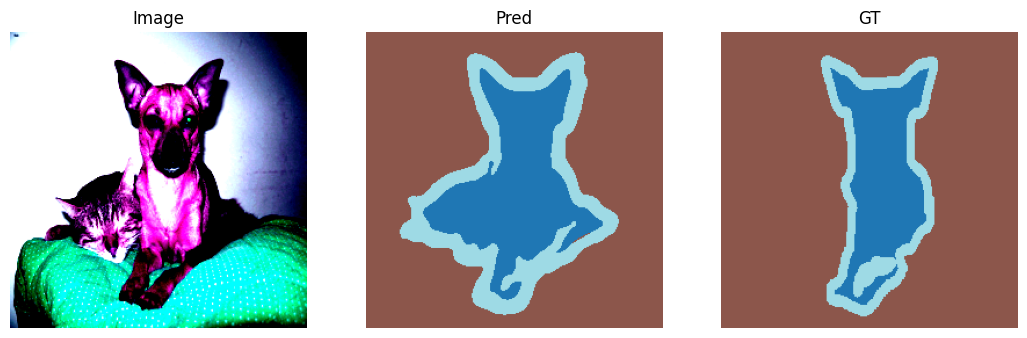

5it [00:01,  3.86it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8556864].


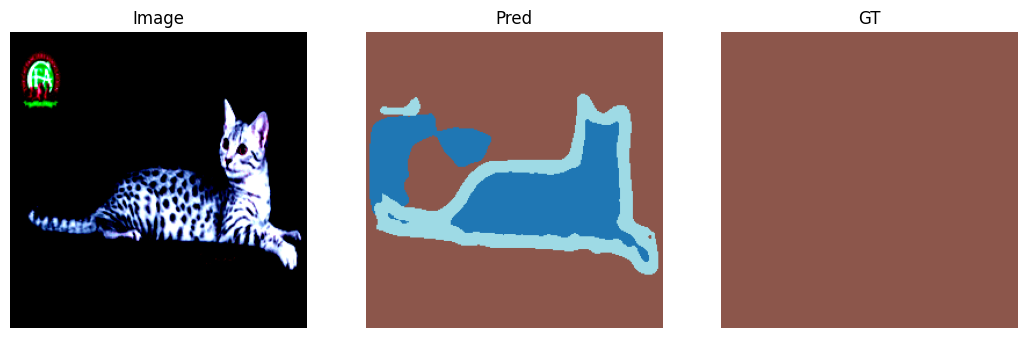

6it [00:01,  4.19it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].


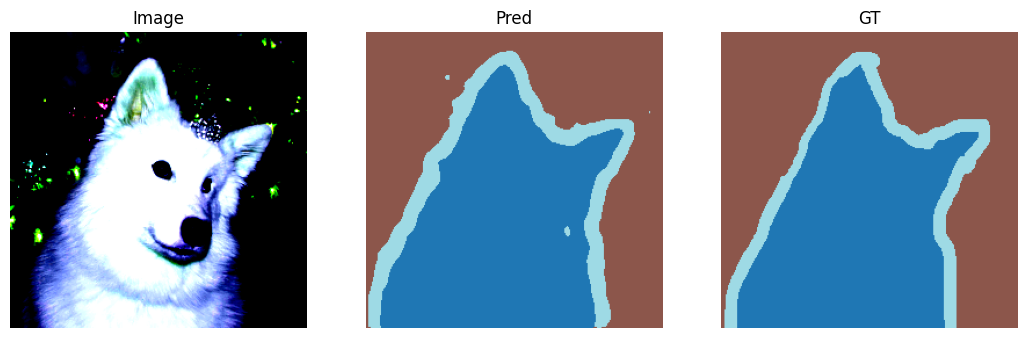

7it [00:01,  4.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


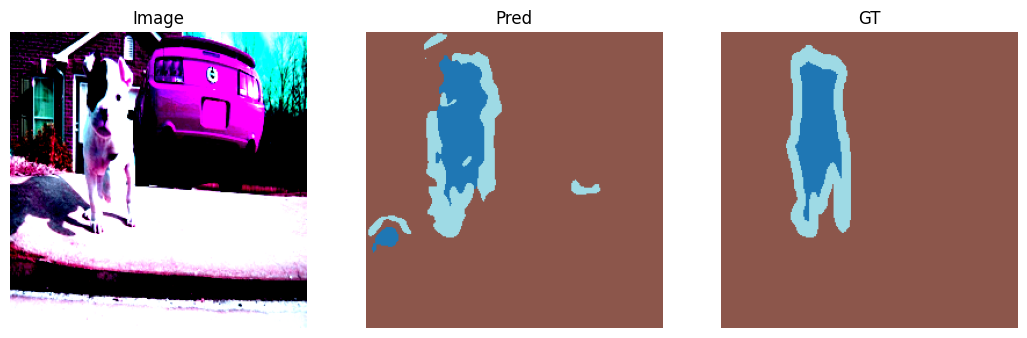

8it [00:02,  4.50it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


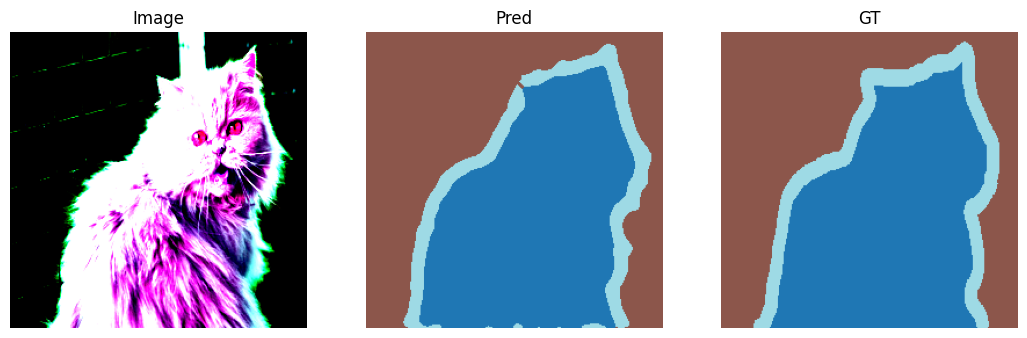

9it [00:02,  4.58it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.5768193].


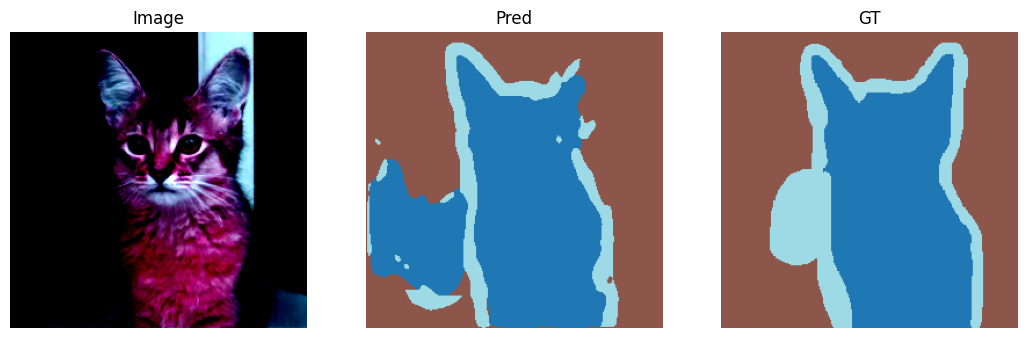

10it [00:02,  4.63it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


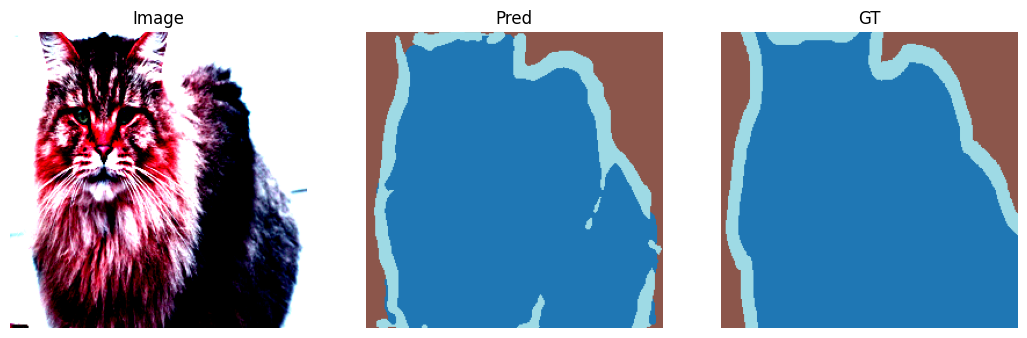

11it [00:02,  4.64it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5882353].


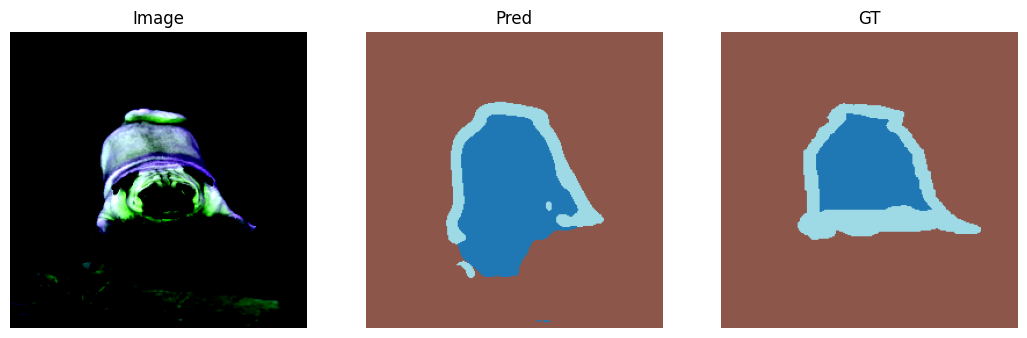

12it [00:03,  4.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


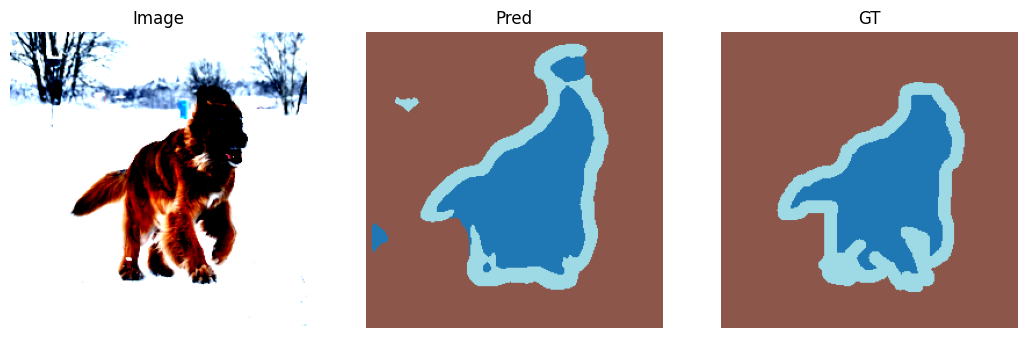

13it [00:03,  4.63it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.64].


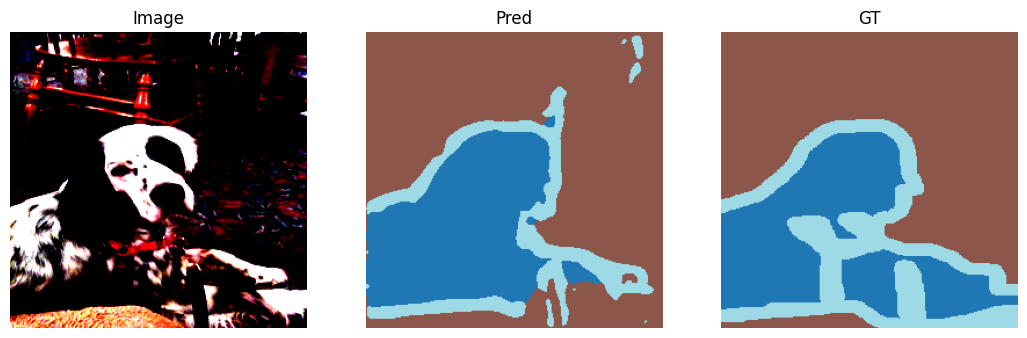

14it [00:03,  4.67it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..1.9383754].


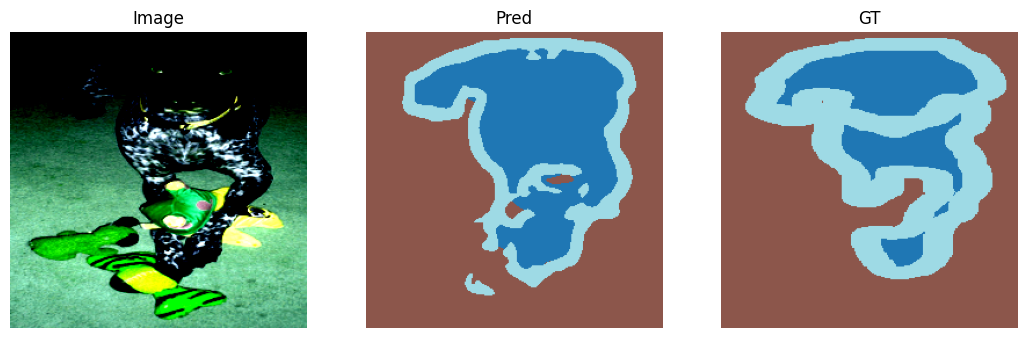

15it [00:03,  4.61it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..1.5593902].


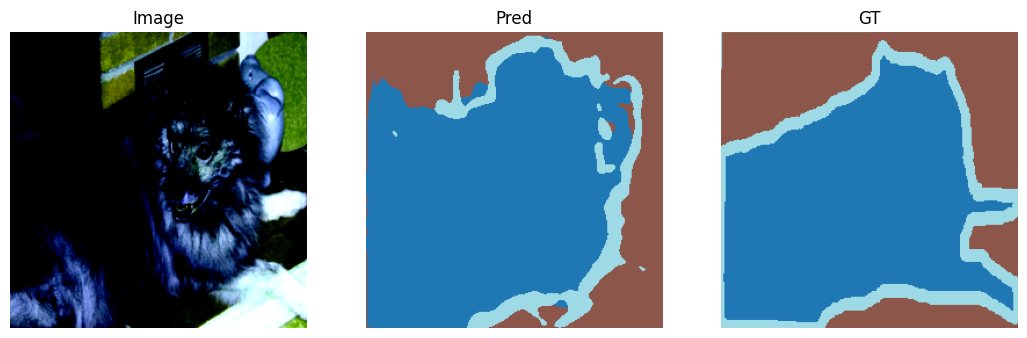

16it [00:03,  4.53it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


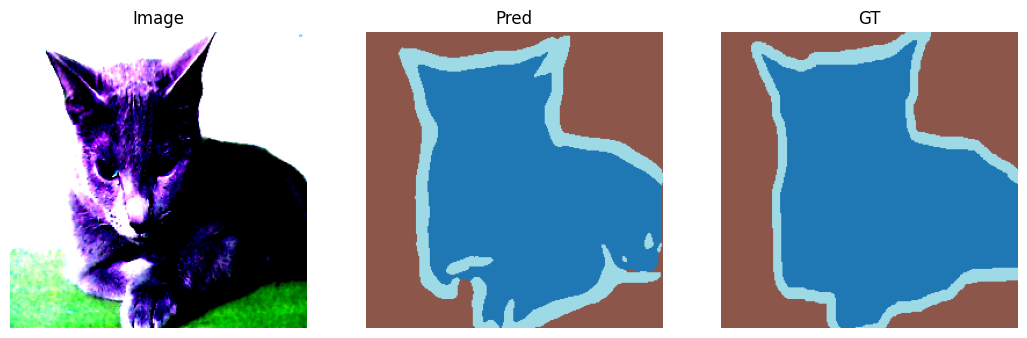

17it [00:04,  4.47it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5593902].
17it [00:04,  3.80it/s]


KeyboardInterrupt: 

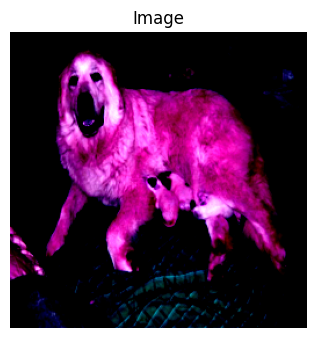

In [25]:
import numpy as np
import cv2

# class index → RGB 컬러
colors = {
    0: (0, 0, 0),       # background
    1: (255, 0, 0),     # class1
    2: (0, 255, 0),     # class2
}

def decode_segmap(mask):
    h,w = mask.shape
    result = np.zeros((h,w,3), dtype=np.uint8)
    for cls, color in colors.items():
        result[mask == cls] = color
    return result

test_loader = DataLoader(test_dataset, batch_size=1,num_workers=8, pin_memory=True)

model = UNet(n_channels=3, n_classes=3, bilinear=bilinear).to(device)
state_dict = torch.load("/content/segmentation_checkpoints/best_model.pth", map_location=device)
model.load_state_dict(state_dict['model_state_dict'])

save_dir = "/content/seg_results/"
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
  model.eval()
  for i, (images, masks) in tqdm(enumerate(test_loader)):
    images = images.to(device)
    pred = model(images) # (1, 3, H, W)
    pred_mask = torch.argmax(pred, dim=1) # (1, H, W)
    # Visualize
    img, gt_mask, pred_mask = images[0].cpu(), masks[0].cpu(), pred_mask[0].cpu()
    visualize_with_image(img, pred_mask, gt_mask, num_classes=model.n_classes)

    mask_np = pred_mask.squeeze().cpu().numpy().astype(np.uint8)
    # 파일 이름 저장
    save_path = os.path.join(save_dir, f"mask_{i}.png")
    color_mask = decode_segmap(mask_np)
    cv2.imwrite(save_path, color_mask)

print(f"\n📌 Saved inference masks to: {save_dir}")

## 기타

In [6]:
### Image normalize (mean, std) 계산 방법 ###

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def compute_mean_std(loader):
    mean = 0.
    std = 0.
    total = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std  += images.std(2).sum(0)
        total += batch_samples

    mean /= total
    std  /= total
    return mean, std

dataset = datasets.ImageFolder("train_images",
    transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean, std = compute_mean_std(loader)
print(mean, std)

FileNotFoundError: [Errno 2] No such file or directory: 'train_images'